# Jupyter Notebook to run Nano-DMS-MaP pipeline

Note: Shell commands are all executed on Slurm cluster here using slurmpy. Adapt to specific needs if required. For example, when running locally, the commands may be executed by `!{command}` (in jupyter notebooks) or `subprocess.run(command)`. 

To install slurmpy run `pip install -U slurmpy` in an active Nano-DMS-MaP conda environment to install. 

# folder structures:

experiment/data/

                fastq/       sample/
                fastq_stats/ sample
                
                isoquant/    sample
                
                bam/         sample
                bam_stats/   sample
                
                rfcount/     sample
                rfnorm/      sample
                rfcombine/   sample
                reactivities/sample
                eterna_out/  sample
                
                #optional:
                subsample_bam/      sample
                subsample_rfcount/  sample
                subsample_rfnorm/   sample
                subsample_rfcombine/sample
                
                
experiment/references/

                    *.fa #full length reference_fasta
                    
                    *.gtf #(isoform information), created with 0_create_gtf.ipynb
                    
                    *.db #"truth" structure, required only for evaluation, e.g. ROC-AUC and BPS/PPV
                    
                    transcripts_PCR*/*.fa #individual fasta file for each isoform (generated with 0_create_gtf.ipynb)

Notes:
fastq files should be gzipped to work with some tools here. 

In [1]:
#use an excel (xlsx) sheet for samples, with required columns "sample" and "barcode", samples must not contain spaces

import pandas as pd
samplesheet = pd.read_excel("./Samplesheet_example.xlsx", engine="openpyxl")
samplesheet

,sample,sequencing run,barcode
0,Nanopore_HIV1_Rep1_RT-US_0mM_cell,Run1,barcode01
1,Nanopore_HIV1_Rep1_RT-US_57mM_cell,Run1,barcode05
2,Nanopore_HIV1_Rep1_RT-US_85mM_cell,Run1,barcode06
3,Nanopore_HIV1_Rep2_RT-US_0mM_cell,Run2,barcode01
4,Nanopore_HIV1_Rep2_RT-US_57mM_cell,Run2,barcode05
5,Nanopore_HIV1_Rep2_RT-US_85mM_cell,Run2,barcode06
6,Nanopore_HIV1_Rep1_RT-FS_0mM_cell,Run1,barcode21
7,Nanopore_HIV1_Rep1_RT-FS_57mM_cell,Run1,barcode25
8,Nanopore_HIV1_Rep1_RT-FS_85mM_cell,Run1,barcode26
9,Nanopore_HIV1_Rep2_RT-FS_0mM_cell,Run2,barcode21


In [2]:
samples = samplesheet["sample"].values
samples

array(['Nanopore_HIV1_Rep1_RT-US_0mM_cell',
       'Nanopore_HIV1_Rep1_RT-US_57mM_cell',
       'Nanopore_HIV1_Rep1_RT-US_85mM_cell',
       'Nanopore_HIV1_Rep2_RT-US_0mM_cell',
       'Nanopore_HIV1_Rep2_RT-US_57mM_cell',
       'Nanopore_HIV1_Rep2_RT-US_85mM_cell',
       'Nanopore_HIV1_Rep1_RT-FS_0mM_cell',
       'Nanopore_HIV1_Rep1_RT-FS_57mM_cell',
       'Nanopore_HIV1_Rep1_RT-FS_85mM_cell',
       'Nanopore_HIV1_Rep2_RT-FS_0mM_cell',
       'Nanopore_HIV1_Rep2_RT-FS_57mM_cell',
       'Nanopore_HIV1_Rep2_RT-FS_85mM_cell'], dtype=object)

# Generating fastq files

### Note: 

In this example basecalling was already performed and fastq files of the same sample generated from multiple sequencing runs were concatenated. 

The fastq files are available at SRA at the following URL: https://www.ncbi.nlm.nih.gov/Traces/study/?query_key=1&WebEnv=MCID_64c900fec202961a49b089d2&f=localization_sam_s%3An%3Acell%3Brt_pcr_primers_sam_s%3An%3Art-us%2Crt-fs%3Bdms_conc_sam_s%3An%3A0mm%2C57mm%2C85mm%3Bisolation_source_sam_ss_dpl262_ss%3An%3Acell%2520culture%3Binstrument_s%3An%3Aminion%3Bbiosamplemodel_sam_ss%3An%3Aviral%3Ac&o=acc_s%3Aa#


For own data follow the basecalling instructions as described in "Standard workflow"

## For example data: Sorting the downloaded fastq files from SRA

In [4]:
import os

SRA_fastq_dir = f"{path_to_downloaded_SRA}/virus/"

os.makedirs(data_folder, exist_ok=True)

In [21]:
#specify absolute path to data folder
data_folder = f"{os.getcwd()}/data"


In [5]:
for sample in samples:
    sample_fastq_dir = f"{data_folder}/fastq/{sample}"
    os.makedirs(sample_fastq_dir, exist_ok=True)
    !cp {SRA_fastq_dir}/{sample}.fastq.gz {sample_fastq_dir}/merged.fastq.gz

## Standard workflow: Basecalling from fast5 files

In [139]:
fastq_folder = f"{...}/basecall_output"
fast5_folder = f"{...}/raw_sequencing_output"

guppy = f"{...}/tools/guppy/ont-guppy_6.4.6/bin/guppy_basecaller"

Note: Take care to chose the correct config for your acquired reads. The reads in the example were acquired with Kit12 on R10.4 flow cells, at 400 bps translocation speed and 4 kHz sampling rate, and thus the R10.4_e8.1_sup config was chosen. 

For sequencing with new Kit 14 chemistry and a current MinKNOW version (acquiring at 5 kHz) update the config file respectively (to r10.4.1_e8.2_400bps_sup@4.2.0)

For more info about models you can check https://github.com/nanoporetech/dorado#dna-models



In [ ]:
job_name = "basecall"
num_threads = 6
s = Slurm(job_name, {"partition" : "gpu", "mem" : "50G", "gres" : "gpu:a100:2", "cpus-per-task" : num_threads, "time" : "240"})

config = 'dna_r10.4_e8.1_sup.cfg'
barcode_kit = 'SQK-NBD112-96'

for run in ["Run1", "Run2"]:
    fast5_dir = f"{fast5_folder}/{run}"
    fastq_dir = f"{fastq_folder}/{run}"
    os.makedirs(fastq_dir, exist_ok=True)
    
    
    command = f"{guppy} -x cuda:all --do_read_splitting --enable_trim_barcodes --trim_adapters --min_qscore 10 --trim_strategy dna -r -c {config} --barcode_kits {barcode_kit} -i {fast5_dir} -s {fastq_dir}"
    s.run(command)
    


## Sort Fastq files (from barcode to sample)
After basecalling with guppy multiple fastq.gz files will be generated per barcode. For downstream work it is highly beneficial to have a single fastq.gz file per sample. If you performed multiple sequencing runs per sample you can also merge fastq.gz files from multiple runs here.

It is possible to merge multiple fastq (.gz) files by concatenation with `cat`, but you can also first unzip them with `zcat` and then rezip them with `gzip` to save storage space. 

In [6]:
fastq_folder = f"{...}/basecall_output"


In [ ]:
for _, row in samplesheet.iterrows():
    sample = row["sample"]
    barcode = row["barcode"]
    run = row["sequencing run"]

    barcode_fastq_folder = f"{fastq_folder}/{run}/pass/{barcode}"
    sample_fastq_folder = f"{data_folder}/fastq/{sample}"
    os.makedirs(sample_fastq_folder, exist_ok=True)
    
    !cat {barcode_fastq_folder}/*.fastq | gzip > {sample_fastq_folder}/merged.fastq.gz


## [QC] Plot virtual gels

In [5]:
# specify path to the calc_per_read_rust binary that is located in the functions folder in the Nano-DMS-MaP github
calc_fastq_stats = f"{os.getcwd()}/tools/fquick/target/release/fastq_stats"

In [10]:
# Extract fastq statistics (read length and quality)

from slurmpy import Slurm

job_name = "fastqstats"
num_threads = 1
s = Slurm(job_name, {"partition" : "cpu", "mem" : "10G", "cpus-per-task" : num_threads, "time" : "20"})

os.makedirs(f"{data_folder}/fastq_stats", exist_ok=True)

for sample in samples:
    fastq_file = f"{data_folder}/fastq/{sample}/merged.fastq.gz"
    fastq_stats_file = f"{data_folder}/fastq_stats/{sample}_merged"
    command = f"{calc_fastq_stats} {fastq_file} {fastq_stats_file}"
    s.run(command)
    

b'Submitted batch job 1692544'
b'Submitted batch job 1692545'
b'Submitted batch job 1692546'
b'Submitted batch job 1692547'
b'Submitted batch job 1692548'
b'Submitted batch job 1692549'
b'Submitted batch job 1692550'
b'Submitted batch job 1692551'
b'Submitted batch job 1692552'
b'Submitted batch job 1692553'
b'Submitted batch job 1692554'
b'Submitted batch job 1692555'


In [6]:
from tools.python_functions.plot_virtual_gel import plot_virtual_gel

In [7]:
sample_read_lengths = {}
tmp_data = []
for sample in samples:
    fastq_stats_file = f"{data_folder}/fastq_stats/{sample}_merged_read_stats.csv.gz"
    tmp_df = pd.read_csv(fastq_stats_file, sep=",")
    sample_read_lengths[sample] = tmp_df["read_length"].values
    tmp_df["sample"] = sample
    tmp_data.append(tmp_df)
read_stats_df = pd.concat(tmp_data)

In [8]:
os.makedirs("figures", exist_ok=True)

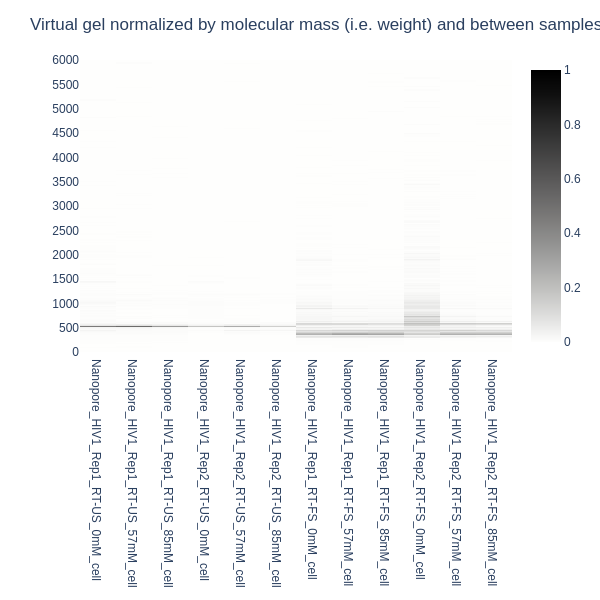

In [9]:
max_length = 6000
fig = plot_virtual_gel(samples, sample_read_lengths, width=600, mass=True, norm_mass=True, norm_percentile=100, max_read_length = max_length)
fig.update_yaxes(dtick=500)
fig.write_image(f"figures/virtual_gel_{max_length}nt.svg")
fig.show(renderer="png")

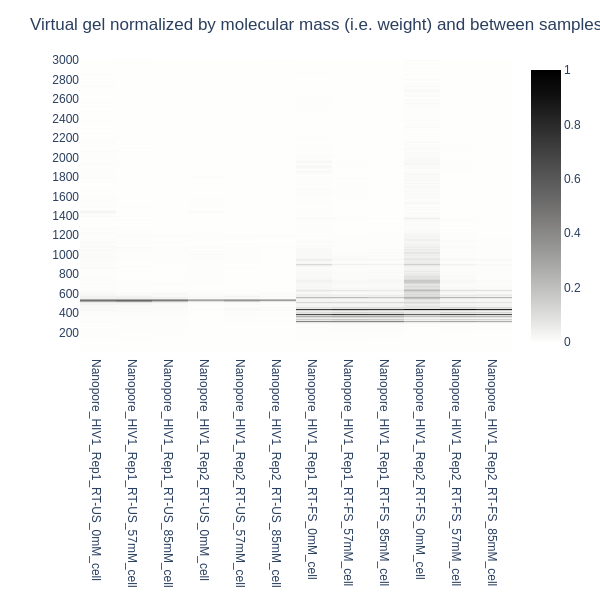

In [10]:
max_length = 3000
fig = plot_virtual_gel(samples, sample_read_lengths, width=600, mass=True, norm_mass=True, norm_percentile=100, max_read_length = max_length)
fig.update_yaxes(dtick=200)
fig.write_image(f"figures/virtual_gel_{max_length}nt.svg")
fig.show(renderer="png")

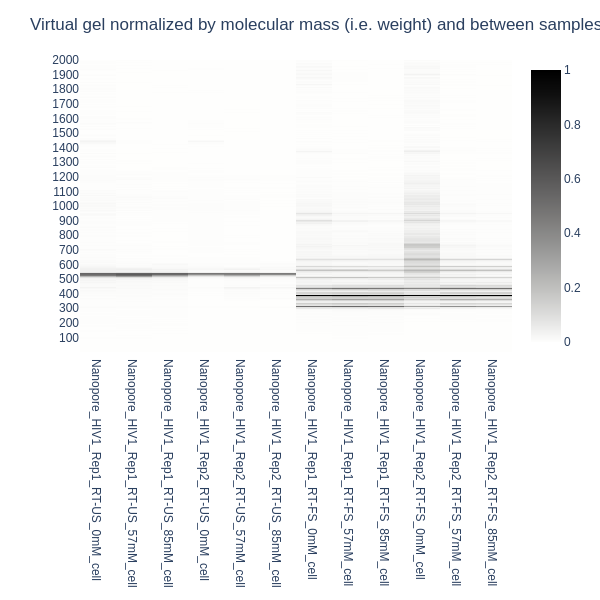

In [11]:
max_length = 2000
fig = plot_virtual_gel(samples, sample_read_lengths, width=600, mass=True, norm_mass=True, norm_percentile=100, max_read_length = max_length)
fig.update_yaxes(dtick=100)
fig.write_image(f"figures/virtual_gel_{max_length}nt.svg")
fig.show(renderer="png")

## [QC] Plot read quality score distribution

In [12]:
#plotly libraries
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.io as pio

#default renderer (svg means very small file size, visibility on github, high quality, but requires sometimes setting height and width)
pio.renderers.default = "svg"

colors = ["#363b3d", "#727b76", "#31a240", "#f93939", "#f79118", "#de7b06", "#9b308f", "#dc759b"]

#additional defaults
px.defaults.color_discrete_sequence = ["rgb(100,100,100)"] + pc.qualitative.D3
px.defaults.width=1000
px.defaults.height=800

#set default template as "simple_white" (no background, no grid lines)
pio.templates["simple_white"].layout["yaxis"]["showgrid"] = True
pio.templates.default = "simple_white"

import numpy as np

import sklearn.metrics as metrics
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

colorscale = pc.sequential.Plasma
colorscale = [colorscale[0]] + colorscale[3:8]

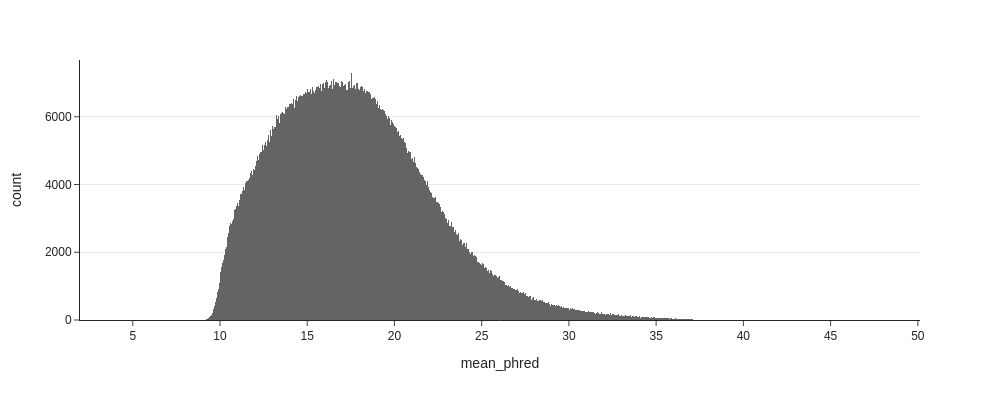

In [68]:
fig = px.histogram(read_stats_df, x="mean_phred")
fig.update_traces(marker_line_width=0)
fig.update_layout(height=400)
fig.show(renderer='png')

### Plot per position quality score distributions

In [15]:
tmp_data = []
for sample in samples:
    phred_stats_file = f"{data_folder}/fastq_stats/{sample}_merged_phred_hist.csv"
    tmp_df = pd.read_csv(phred_stats_file, sep=",")
    tmp_df["sample"] = sample
    tmp_data.append(tmp_df)
phred_stats_df = pd.concat(tmp_data)

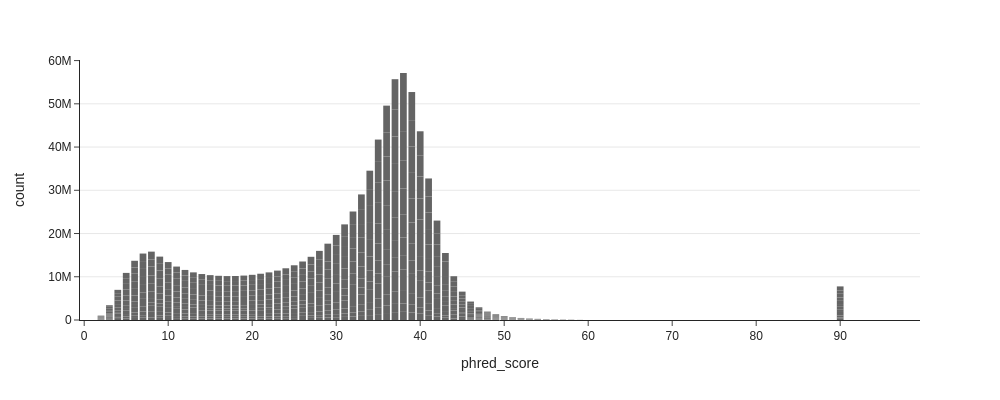

In [20]:
fig = px.bar(phred_stats_df, x="phred_score", y='count')
fig.update_layout(height=400)
fig.update_xaxes(dtick=10)
fig.update_traces(marker_line_width=0)
fig.show(renderer='png')

# Isoquant

In [ ]:
# Isoquant (https://www.nature.com/articles/s41587-022-01565-y) attempts to assign each read to a specific isoform. 
# A fasta reference of the unspliced genome and a GTF file to name the transcripts is required. The GTF file is based on https://retrovirology.biomedcentral.com/articles/10.1186/s12977-020-00533-1,
# but modified (in 0.create_gtf.ipynb) to include the PCR primer workflow

# The fastq files are specified according to:
# https://github.com/ablab/IsoQuant#specifying-input-data-via-dataset-description-file

In [152]:
import os

gtf_file = f"{os.getcwd()}/references/HIV1-NL43_all_iso_PCR1_2_3.gtf"
ref_file = f"{os.getcwd()}/references/HIV1-NL43.fa"

In [153]:
from slurmpy import Slurm

samples = sorted(samples)

job_name = "isoquant"
num_threads = 5
s = Slurm(job_name, {"partition" : "cpu", "mem" : "10G", "cpus-per-task" : num_threads, "time" : "240"})

output_folder = f"{data_folder}/isoquant/"
os.makedirs(output_folder, exist_ok=True)

with open(output_folder + "fastq_list.txt", "w") as outfile:
    for sample in samples:
        
        #adjust fastq file name if named differently
        fastq_file = f"{data_folder}/fastq/{sample}/merged.fastq.gz"
        outfile.write(f"#{sample}\n{fastq_file}:{sample}\n")
        
command = f"isoquant.py -d nanopore -g {gtf_file} -r {ref_file} --fastq_list {output_folder}fastq_list.txt --stranded none -t {num_threads} -o {output_folder} --clean_start --fl_data"
s.run(command)

b'Submitted batch job 1197314'


1197314

# Run 2_plot_isoquant.ipynb to plot isoquant results (check alignment statistics for QC)

### Sort per isoform

After Isoquant finishes successfully, the following script will take the read to isoform assignments and sort into individual fastq files

In [25]:
# specify location of python script located in functions directory of Nano-DMS-MaP github
sort_fastq = f"{os.getcwd()}/tools/python_functions/sort_fastq.py"

In [38]:
#Sorting reads by isoform
from slurmpy import Slurm
from Bio import SeqIO

fastq_dir = f"{data_folder}/fastq/"

job_name = "sortfq"
num_threads = 1
s = Slurm(job_name, {"partition" : "cpu", "mem" : "20G", "cpus-per-task" : num_threads, "time" : "240"})


for sample in samples:
    fastq_out_prefix = f"{data_folder}/fastq/{sample}/by_isoform/"
    os.makedirs(fastq_out_prefix, exist_ok=True)
    
    fastq_infile = f'{data_folder}/fastq/{sample}/merged.fastq.gz'
    read_assignment_file = f'{data_folder}/isoquant/{sample}/{sample}.read_assignments.tsv'
    
    command = f"python {sort_fastq} -fi {fastq_infile} -fo {fastq_out_prefix} -ir {read_assignment_file}"
    
    s.run(command)

b'Submitted batch job 1693247'
b'Submitted batch job 1693248'
b'Submitted batch job 1693249'
b'Submitted batch job 1693250'
b'Submitted batch job 1693251'
b'Submitted batch job 1693252'
b'Submitted batch job 1693253'
b'Submitted batch job 1693254'
b'Submitted batch job 1693255'
b'Submitted batch job 1693256'
b'Submitted batch job 1693257'
b'Submitted batch job 1693258'


# Alignment

### Find isoforms that are present in both samples

In [39]:
def get_combined_sample(sample):
    return "_".join(sample.split("_")[3:5]) # adjust to your naming scheme

Here we set a minimum read count filter to ensuree that we don't run analysis on isoforms with no reads. 
This does not generally need to be tuned, as the evaluation for which isoforms have enough coverage comes later with 
correlation between replicates

Note that we're loading a dataframe here that we previously generated in Notebook 2. 

In [40]:
read_counts_df = pd.read_pickle(f"{data_folder}/isoquant/read_counts.pickle")

In [41]:
per_replicate_df = pd.pivot(read_counts_df, index = ["RT_and_DMS", "isoform_id"], columns = "replicate", values = "count").reset_index()

min_cov = 200
min_cov_df = per_replicate_df[(per_replicate_df["Rep1"] > min_cov) & (per_replicate_df["Rep2"] > min_cov)]
isoforms_per_combined_sample = min_cov_df.groupby("RT_and_DMS").agg({"isoform_id" : list}).to_dict()["isoform_id"]

In [42]:
import numpy as np

isoforms = np.unique(min_cov_df["isoform_id"].values)
print(f"Detected {len(isoforms)} unique isoforms throughout all samples with coverage above {min_cov}")

Detected 29 unique isoforms throughout all samples with coverage above 200


## Per isoform alignment to reference

In [47]:
#folder that contains references of individual isoforms (generated by 0._GTF_preprocess.ipynb)
reference_dir = f"{os.getcwd()}/references/transcripts_PCR1_2_3" 

### Generate per isoform reference indices

In [45]:
#index reference
#generate last db file of fasta for all detected isoforms

slurm_index = Slurm("index", {"partition" : "cpu", "mem" : "5G", "cpus-per-task" : 1, "time" : "10"})

for isoform in isoforms:
    reference_fasta = f"{reference_dir}/{isoform}.fa"
    last_reference_prefix = f"{reference_dir}/{isoform}_LAST"
    command = f"""lastdb -uNEAR {last_reference_prefix} {reference_fasta}
    samtools faidx {reference_fasta}
    """
    slurm_index.run(command)

b'Submitted batch job 1693741'
b'Submitted batch job 1693742'
b'Submitted batch job 1693743'
b'Submitted batch job 1693744'
b'Submitted batch job 1693745'
b'Submitted batch job 1693746'
b'Submitted batch job 1693747'
b'Submitted batch job 1693748'
b'Submitted batch job 1693749'
b'Submitted batch job 1693750'
b'Submitted batch job 1693751'
b'Submitted batch job 1693752'
b'Submitted batch job 1693753'
b'Submitted batch job 1693754'
b'Submitted batch job 1693755'
b'Submitted batch job 1693756'
b'Submitted batch job 1693757'
b'Submitted batch job 1693758'
b'Submitted batch job 1693759'
b'Submitted batch job 1693760'
b'Submitted batch job 1693761'
b'Submitted batch job 1693762'
b'Submitted batch job 1693763'
b'Submitted batch job 1693764'
b'Submitted batch job 1693765'
b'Submitted batch job 1693766'
b'Submitted batch job 1693767'
b'Submitted batch job 1693768'
b'Submitted batch job 1693769'


### Align per isoform with LAST

In [162]:
pids = {}

num_threads = 10

slurm_train = Slurm("LAST_train", {"partition" : "cpu", "mem" : "5G", "cpus-per-task" : num_threads, "time" : "20"})
slurm_align = Slurm("LAST_align", {"partition" : "cpu", "mem" : "5G", "cpus-per-task" : num_threads, "time" : "120"})

os.makedirs(f"{data_folder}/bam", exist_ok=True)

for sample in samples:
    
    combined_sample = get_combined_sample(sample)
    
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    commands = []
    for isoform in sample_isoforms:
        
        reference_fasta = f"{reference_dir}/{isoform}.fa"
        last_reference_prefix = f"{reference_dir}/{isoform}_LAST"
    
        bam_outdir = f"{data_folder}/bam/{sample}/"
        fastq_file = f"{data_folder}/fastq/{sample}/by_isoform/{isoform}.fastq.gz"
        
        os.makedirs(bam_outdir, exist_ok=True)
        #train LAST
        command = f"""
        last-train -Q0 -P {num_threads} {last_reference_prefix} {fastq_file} > {bam_outdir}/LAST_train_{isoform}.par
        """
        commands.append(command)
    train_pid = slurm_train.run("\n".join(commands))
    
    commands = []
    for isoform in sample_isoforms:
        reference_fasta = f"{reference_dir}/{isoform}.fa"
        last_reference_prefix = f"{reference_dir}/{isoform}_LAST"
    
        bam_outdir = f"{data_folder}/bam/{sample}/"
        fastq_file = f"{data_folder}/fastq/{sample}/by_isoform/{isoform}.fastq.gz"
        
        #align LAST
        
        command = f"""
        lastal -Qkeep -P {num_threads} -p {bam_outdir}/LAST_train_{isoform}.par -m20 {last_reference_prefix} {fastq_file} | last-split -m1 | maf-convert sam | samtools view -h -t {reference_fasta}.fai > {bam_outdir}/LAST_{isoform}.bam

        samtools calmd --output-fmt BAM --threads {num_threads} {bam_outdir}/LAST_{isoform}.bam {reference_fasta} > {bam_outdir}/LAST_MD_{isoform}.bam
        samtools sort -O bam {bam_outdir}/LAST_MD_{isoform}.bam > {bam_outdir}/LAST_{isoform}.bam
        samtools index {bam_outdir}/LAST_{isoform}.bam
        rm {bam_outdir}/LAST_MD_{isoform}.bam
        """
        commands.append(command)
    
    pids[f"{sample}"] = slurm_align.run("\n".join(commands), depends_on = [train_pid])

b'Submitted batch job 1197539'
b'Submitted batch job 1197540'
b'Submitted batch job 1197541'
b'Submitted batch job 1197542'
b'Submitted batch job 1197543'
b'Submitted batch job 1197544'
b'Submitted batch job 1197545'
b'Submitted batch job 1197546'
b'Submitted batch job 1197547'
b'Submitted batch job 1197548'
b'Submitted batch job 1197549'
b'Submitted batch job 1197550'
b'Submitted batch job 1197551'
b'Submitted batch job 1197552'
b'Submitted batch job 1197553'
b'Submitted batch job 1197554'
b'Submitted batch job 1197555'
b'Submitted batch job 1197556'
b'Submitted batch job 1197557'
b'Submitted batch job 1197558'
b'Submitted batch job 1197559'
b'Submitted batch job 1197560'
b'Submitted batch job 1197561'
b'Submitted batch job 1197562'


## [QC] Run Perbase and Samtools depth to evaluate mutation rates and coverage

In [165]:
pids = {}

num_threads = 1

minq = 22

slurm_bamqc = Slurm("bamqc", {"partition" : "cpu", "mem" : "5G", "cpus-per-task" : num_threads, "time" : "10"})

bamstats_folder = f"{data_folder}/bam_stats"
os.makedirs(bamstats_folder, exist_ok=True)

for sample in samples:
    
    combined_sample = get_combined_sample(sample)
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    sample_outfolder = f"{bamstats_folder}/{sample}/"
    os.makedirs(sample_outfolder, exist_ok=True)
    
    commands = []
    for isoform in sample_isoforms:
    
        bam_file = f"{data_folder}/bam/{sample}/LAST_{isoform}.bam"
        reference_fasta = f"{reference_dir}/{isoform}.fa"
        
        perbase_outfile = f"{sample_outfolder}/perbase_{sample}_{isoform}.tsv.gz"
        coverage_outfile = f"{sample_outfolder}/coverage_{sample}_{isoform}.csv"

        command = f"""
        perbase base-depth -Q {minq{ -r {reference_fasta} {bam_file} | gzip > {perbase_outfile}
        samtools depth {bam_file} > {coverage_outfile}
        """
        
        commands.append(command)
        
    pids[f"{sample}"] = slurm_bamqc.run("\n".join(commands))

b'Submitted batch job 1197678'
b'Submitted batch job 1197679'
b'Submitted batch job 1197680'
b'Submitted batch job 1197681'
b'Submitted batch job 1197682'
b'Submitted batch job 1197683'
b'Submitted batch job 1197684'
b'Submitted batch job 1197685'
b'Submitted batch job 1197686'
b'Submitted batch job 1197687'
b'Submitted batch job 1197688'
b'Submitted batch job 1197689'


### Plot results of perbase and coverage in "3_plot_mutation_rate_and_coverage_per_isoform.ipynb"

# Mutational Profiling analysis with RNA-Framework

RNA-Framework version 2.8.3 was used for the example dataset. It is majorly written in perl. 

(To run rfnorm the conda package "perl-xml-libxml" is required.)

In [57]:
#specify path to RNAFramework
rf_dir = f"{os.getcwd()}/tools/RNAFramework" 
!ls {rf_dir}/

CHANGELOG.md  rf-compare       rf-index		  rf-mutate	    tests
index.rst     rf-correlate     rf-jackknife	  rf-norm	    VERSION
lib	      rf-count	       rf-json2rc	  rf-peakcall
LICENSE       rf-count-genome  rf-map		  rf-rctools
README.md     rf-duplex        rf-modcall	  rf-structextract
rf-combine    rf-fold	       rf-motifdiscovery  rf-wiggle


## rf-count

In [61]:
os.makedirs("data/rfcount", exist_ok=True)

def rf_count(rf_dir, data_folder, sample, isoform, reference_fasta, minq = 22, num_threads = 10):
    commands = []

    bam_file = f"{data_folder}/bam/{sample}/LAST_{isoform}.bam"
    rc_outdir = f"{data_folder}/rfcount/{sample}/{isoform}/"
    os.makedirs(rc_outdir, exist_ok=True)

    #to run rf-count with different settings comment/uncomment commands (and adjust output_dir naming)

    # Here we count all single point mutations (ignoring indels) except G>A mutations, because those are not informative for WC-basepairing, but for N7G
    # If you are interested in evaluating N7G methylation status you can filter to only have G>A mutations
    # Note that this mutation counting step is independent of normalization of DMS reactivities, which will be performed in rf-norm, 
    # so even if you only want to look at A and C mutations, you don't need to change it to exclude G and U
    
    commands.append(f"{rf_dir}/rf-count -r -p {num_threads} -mf {primer_mask} -o {rc_outdir}/q{minq}_eq10_ndni -ow -f {reference_fasta} --only-mut 'G>CT;A>CGT;C>AGT;T>ACG' -m -nd -ni -q {minq} -eq 10 -mm {bam_file}")
    
    command = "\n".join(commands)

    return command

In [62]:
primer_mask = f"{os.getcwd()}/references/mask_primers_PCR1_2_3.csv"
slurm_rfcount = Slurm("rfcount", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "60"})

#if you want to test different minq cutoffs (depending on basecaller and chemistry updates ...) you can specify a different minq value

for sample in samples:

    combined_sample = get_combined_sample(sample)
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    commands = []
    for isoform in sample_isoforms:
        reference_fasta = f"{os.getcwd()}/references/transcripts_PCR1_2_3/{isoform}.fa"
        
        commands.append(rf_count(rf_dir, data_folder, sample, isoform, reference_fasta))
    slurm_rfcount.run("\n".join(commands))

b'Submitted batch job 1695364'
b'Submitted batch job 1695365'
b'Submitted batch job 1695366'
b'Submitted batch job 1695367'
b'Submitted batch job 1695368'
b'Submitted batch job 1695369'
b'Submitted batch job 1695371'
b'Submitted batch job 1695372'
b'Submitted batch job 1695373'
b'Submitted batch job 1695375'
b'Submitted batch job 1695376'
b'Submitted batch job 1695377'


## rf-norm

In [65]:
rfnorm_outdir = f"{data_folder}/rfnorm/"
os.makedirs(rfnorm_outdir, exist_ok=True)

def rf_norm(rf_dir, data_folder, sample, control, isoform, minq = 22, num_threads = 10):
    pids = {}

    commands = []
    
    #specify the different rf-count outdir names here
    for option in [f"q{minq}_eq10_ndni"]:
        
        #running rfnorm with different reactive nt makes it easier to analyze them afterwards (e.g. for correlation analysis)
        for reactive_nt in ["AC", "ACT", "ACGT"]: #["ACGT", "AC", "ACT", "G"]

            rc_file = f"{data_folder}/rfcount/{sample}/{isoform}/{option}/LAST_{isoform}.rc"
            control_rc_file = f"{data_folder}/rfcount/{control}/{isoform}/{option}/LAST_{isoform}.rc"
            
            rfnorm_outdir = f"{data_folder}/rfnorm/{sample}/{isoform}/{option}_{reactive_nt}"
            
            #standard procedure is using Siegfried method, which normalizes against control sample. Control vs itself does not work here. 
            if sample != control:
                os.makedirs(rfnorm_outdir, exist_ok=True)
                commands.append(f"{rf_dir}/rf-norm -p {num_threads} -t {rc_file} -u {control_rc_file} -o {rfnorm_outdir} --scoring-method 3 --norm-method 2 -rb {reactive_nt} --max-untreated-mut 0.05 --max-mutation-rate 0.5 --norm-independent -ow")
            
            #To get raw reactivities (e.g. for evaluation of total (DMS) mutation rates or signal-to-noise calculation) use the following
            
            #rfnorm_outdir = f"{data_folder}/rfnorm/{sample}/{isoform}/{option}_{reactive_nt}_raw"
            #os.makedirs(rfnorm_outdir, exist_ok=True)
            #commands.append(f"{rf_dir}/rf-norm -p {num_threads} -t {rc_file} -o {rfnorm_outdir} --scoring-method 4 -r -rb {reactive_nt} -ow")

    command = "\n".join(commands)

    return command

In [66]:
slurm_rfnorm = Slurm("rfnorm", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "480"})

for sample in samples:

    #rf-norm with Siegfried requires a control sample. Here we assume the sample is structured as following: 
    #"{replicate}_{RT_primer}_{DMS_conc}_{localization}"
    #adjust the list index if DMS_conc is at a different position

    split_sample = sample.split("_")
    split_sample[4] = "0mM"
    control = "_".join(split_sample)
    combined_control = get_combined_sample(control)
    
    combined_sample = get_combined_sample(sample)
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    commands = []
    for isoform in sample_isoforms:
        if isoform in isoforms_per_combined_sample[combined_control]:
            commands.append(rf_norm(rf_dir, data_folder, sample, control, isoform))
    slurm_rfnorm.run("\n".join(commands))

b'Submitted batch job 1695729'
b'Submitted batch job 1695730'
b'Submitted batch job 1695731'
b'Submitted batch job 1695732'
b'Submitted batch job 1695733'
b'Submitted batch job 1695735'
b'Submitted batch job 1695736'
b'Submitted batch job 1695738'
b'Submitted batch job 1695741'
b'Submitted batch job 1695742'
b'Submitted batch job 1695744'
b'Submitted batch job 1695747'


## rf-correlate and rf-combine

This step combines the data of multiple replicates. The correlation between those replicates is a key quality control metric, without it the interpretation of DMS reactivities is challenging. 

In [67]:
os.makedirs(f"{data_folder}/rfcombine", exist_ok=True)
num_threads = 1
slurm_rfco = Slurm("rfco", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "10"})

for sample in samples:
    if "Rep1" in sample:

        split_sample = sample.split("_")
        split_sample[4] = "0mM"
        control = "_".join(split_sample)
        combined_control = get_combined_sample(control)
        
        combined_sample = get_combined_sample(sample)
        sample_isoforms = isoforms_per_combined_sample[combined_sample]
        sample1 = sample
        sample2 = sample.replace("Rep1", "Rep2")
        
        commands = []

        for isoform in sample_isoforms:

            if isoform in isoforms_per_combined_sample[combined_control]:
                
                os.makedirs(f"{data_folder}/rfcombine/{combined_sample}/{isoform}", exist_ok=True)

                #specify options again as used in rfcount_outdir 
                for option in ["q22_eq10_ndni"]: #["q22_eq10_ndni", "q22_eq10", "default"]

                    #specify reactive_nt again as in rfnorm
                    for reactive_nt in ["AC", "ACT", "ACGT"]: #["ACGT", "AC", "ACT", "G"]

                        #include "_raw" if rfnorm was also run with Zubradt (4)
                        for norm_option in [""]: #["", "_raw"]

                            #assumes 2 replicates currently, extend if more
                            xml1 = f"{data_folder}/rfnorm/{sample1}/{isoform}/{option}_{reactive_nt}{norm_option}/{isoform}.xml"
                            xml2 = f"{data_folder}/rfnorm/{sample2}/{isoform}/{option}_{reactive_nt}{norm_option}/{isoform}.xml"

                            if os.path.isfile(xml1) & os.path.isfile(xml2):

                                xml_combined = f"{data_folder}/rfcombine/{combined_sample}/{isoform}/{option}_{reactive_nt}{norm_option}/"
                                commands.append(f"{rf_dir}/rf-combine -d 6 -o {xml_combined} -ow {xml1} {xml2}")

                                outfile = f"{xml_combined}/correlation.csv"

                                commands.append(f"{rf_dir}/rf-correlate -o {outfile} -ow {xml1} {xml2}")


        slurm_rfco.run("\n".join(commands))

b'Submitted batch job 1696172'
b'Submitted batch job 1696173'
b'Submitted batch job 1696174'
b'Submitted batch job 1696183'
b'Submitted batch job 1696188'
b'Submitted batch job 1696192'


# Generate csv and bpseq from xml files

RNA-Framework generates an xml file containing the sequence and reactivity scores. To facilitate easier processing with downstream tools, such as Varna and Eternafold, we provide functions to read in the xml file and generate standard csv and Eterna-/Contrafold compatible bpseq (https://github.com/eternagame/EternaFold#chemical-mapping) files. 

In [69]:
from tools.python_functions.xml_conversions import read_in_xml, convert_xml_to_bpseq, convert_xml_to_bpseq_trimmed


In [70]:
# makes similar assumptions as rf-combine above
reactivity_dir = f"{data_folder}/reactivities"
os.makedirs(reactivity_dir, exist_ok=True)

for sample in samples:
    if ("Rep1" in sample):

        split_sample = sample.split("_")
        split_sample[4] = "0mM"
        control = "_".join(split_sample)
        combined_control = get_combined_sample(control)
        
        combined_sample = get_combined_sample(sample)
        sample_isoforms = isoforms_per_combined_sample[combined_sample]

        commands = []
        for isoform in sample_isoforms:
            if isoform in isoforms_per_combined_sample[combined_control]:
                for option in ["q22_eq10_ndni"]: #["q22_eq10_ndni", "q22_eq10", "default"]
                    for reactive_nt in ["AC", "ACT", "ACGT"]: #["ACGT", "AC", "ACT", "G"]
                        for norm_option in [""]: #["", "_raw"]
                            os.makedirs(f"{reactivity_dir}/{isoform}/{option}_{reactive_nt}{norm_option}", exist_ok=True)
                            xml_combined = f"{data_folder}/rfcombine/{combined_sample}/{isoform}/{option}_{reactive_nt}{norm_option}/{isoform}.xml"
                            if os.path.isfile(xml_combined):
                                file = read_in_xml(xml_combined, combined_sample)
                                reactivities = file["reactivity"]
                                reactivities = np.nan_to_num(reactivities, nan = -1)
                                reactivity_file = xml_combined.replace(".xml", ".csv")
                                np.savetxt(reactivity_file, reactivities, fmt="%6f")
                                bp_file = xml_combined.replace(".xml", ".bp2seq")
                                convert_xml_to_bpseq(xml_combined, bp_file)
                                !cp {reactivity_file} {reactivity_dir}/{isoform}/{option}_{reactive_nt}{norm_option}/{combined_sample}.csv

                                #lower part is optional, was used to predict HIV-1 unspliced 5' UTR folding
                                length = 380
                                bp_file = bp_file.replace(".bp2seq", f"_{length}nt.bp2seq")
                                convert_xml_to_bpseq_trimmed(xml_combined,bp_file, length)

In [71]:
tmp_data = []

for sample in samples:
    if ("Rep1" in sample):

        split_sample = sample.split("_")
        split_sample[4] = "0mM"
        control = "_".join(split_sample)
        combined_control = get_combined_sample(control)
        
        combined_sample = get_combined_sample(sample)
        sample_isoforms = isoforms_per_combined_sample[combined_sample]

        commands = []
        for isoform in sample_isoforms:
            if isoform in isoforms_per_combined_sample[combined_control]:
                for option in ["q22_eq10_ndni"]: #["q22_eq10_ndni", "q22_eq10", "default"]
                    for reactive_nt in ["AC", "ACT", "ACGT"]: #["ACGT", "AC", "ACT", "G"]
                        for norm_option in [""]:
                            corr_file = f"{data_folder}/rfcombine/{combined_sample}/{isoform}/{option}_{reactive_nt}/correlation.csv"
                            try:
                                corr = pd.read_csv(corr_file, sep=";", names = ["isoform", "pearson", "p_value"])["pearson"].values[0]
                            except:
                                corr = np.nan
                            tmp_data.append((combined_sample, isoform, option, reactive_nt, norm_option, corr))
corr_df = pd.DataFrame(tmp_data, columns = ["sample", "isoform", "rc_option", "reactive_nt", "norm_option", "pearson_corr"])

In [72]:
corr_df = pd.merge(corr_df, per_replicate_df, left_on = ["sample", "isoform"],right_on=["RT_and_DMS", "isoform_id"], how="left")
corr_df["min_coverage"] = corr_df.apply(lambda x: np.min([x["Rep1"], x["Rep2"]]), axis=1)
corr_df["DMS"] = corr_df["sample"].apply(lambda x: x.split("_")[1])

In [73]:

isoforms = [
    'RT1_unspliced1', 
    'RT2_unspliced2', 
    'RT2_Vif2_RT3_Vif1',
    'RT2_Vif3_RT3_Vif6', 
    'RT2_Vif4_RT3_Vif9', 
    'RT2_Vif5_RT3_Vif8',
    'RT2_Vif7', 
    
    'RT2_Vpr3_RT3_Vpr1', 
    'RT2_Vpr4_RT3_Vpr2',
       
    'RT2_Env1_RT3_Nef2', 
    'RT2_Env9_RT3_Nef4', 
    'RT2_Env2_RT3_Rev1',
    'RT2_Env3_RT3_Rev2', 
    'RT2_Env17_RT3_Nef9', 
    'RT2_Env5_RT3_Nef3',
    'RT2_Env13_RT3_Nef5', 
    'RT2_Env18_RT3_Rev13', 
    'RT2_Env10_RT3_Rev7',
    'RT2_Env19_RT3_Nef12', 
    'RT2_Env11_RT3_Rev8', 
    'RT2_Env14_RT3_Rev10',
    'RT2_Env15_RT3_Rev11', 
    'RT2_Env12_RT3_Rev9', 
    'RT2_Env6_RT3_Rev4',
    'RT2_Env7_RT3_Rev5', 
    'RT2_Env4_RT3_Rev3', 
    'RT2_Env8_RT3_Rev6',
    'RT2_Env20_RT3_Nef11', 
    
    'RT2_Tat5_RT3_Tat1', 
    'RT2_Tat6_RT3_Tat2',
    'RT2_Tat7_RT3_Tat3', 
    'RT2_Tat8_RT3_Tat4', 
    'RT2_Tat12_RT3_Tat9',
    'RT3_Tat10', 
    'RT3_Tat11', 
    'RT3_Tat13', 
    'RT3_Tat15', 
    'RT3_Tat16',
    
    'RT3_Rev12', 
    
    'RT3_Nef16', 
    'RT3_Nef15', 
    'RT3_Nef19', 
    'RT3_Nef20',
    'RT3_Nef22', 
    'RT3_Nef23', 
    
    'RT3_sORF1', 
    'RT3_sORF3']


isoform_colors_RT2 = {
    " "  : "white",
    "unspliced" : "grey",
 'RT1_unspliced1': "black",
 'RT2_unspliced2': "black",

 'RT2_Env1_RT3_Nef2': "rgb(26,82,118)",
 'RT2_Env2_RT3_Rev1': "rgb(31,97,141)",
 'RT2_Env3_RT3_Rev2': "rgb(36,113,163)",
 'RT2_Env4_RT3_Rev3': "rgb(41,128,185)", 
 'RT2_Env5_RT3_Nef3': "rgb(84,153,199)",
 'RT2_Env6_RT3_Rev4': "rgb(127,179,213)",
 'RT2_Env7_RT3_Rev5': "rgb(169,204,227)", 
 'RT2_Env8_RT3_Rev6': "rgb(27,79,114)",
 'RT2_Env9_RT3_Nef4': "rgb(33,97,140)",
 'RT2_Env10_RT3_Rev7': "rgb(40,116,166)",
 'RT2_Env11_RT3_Rev8': "rgb(46,134,163)",
 'RT2_Env12_RT3_Rev9': "rgb(52,152,219)", 
 'RT2_Env13_RT3_Nef5': "rgb(93,173,226)",
 'RT2_Env14_RT3_Rev10': "rgb(133,193,233)",
 'RT2_Env15_RT3_Rev11': "rgb(174,214,241)",
 'RT2_Env17_RT3_Nef9': "rgb(84,153,199)",
 'RT2_Env18_RT3_Rev13': "rgb(127,179,213)",
 'RT2_Env19_RT3_Nef12': "rgb(169,204,224)",
 'RT2_Env20_RT3_Nef11': "rgb(174,214,241)", 
    
 'RT3_Nef16': "grey",
    'RT3_Nef15': "grey", 
    'RT3_Nef19': "grey", 
    'RT3_Nef20': "grey",
    'RT3_Nef22': "grey", 
    'RT3_Nef23': "grey", 

    'RT3_Rev12':"grey", 

 'RT2_Tat5_RT3_Tat1': "rgb(207,87,161)",
 'RT2_Tat6_RT3_Tat2': "rgb(217,144,188)",
 'RT2_Tat7_RT3_Tat3': "rgb(237,206,228)",
 'RT2_Tat8_RT3_Tat4': "rgb(221,168,200)",
 'RT2_Tat12_RT3_Tat9': "rgb(229,186,216)",

    'RT3_Tat10': "grey", 
    'RT3_Tat11': "grey", 
    'RT3_Tat13': "grey", 
    'RT3_Tat15': "grey", 
    'RT3_Tat16': "grey",
    
 'RT2_Vif2_RT3_Vif1': "rgb(96,22,135)",
 'RT2_Vif3_RT3_Vif6': "rgb(141,74,176)",
 'RT2_Vif4_RT3_Vif9': "rgb(170,89,212)",
 'RT2_Vif5_RT3_Vif8': "rgb(204,108,255)",
    'RT2_Vif7':"rgb(142,68,173)",
    
 'RT2_Vpr3_RT3_Vpr1': "rgb(168,30,45)",
 'RT2_Vpr4_RT3_Vpr2': "rgb(192,98,106)",

 'RT3_sORF1': "rgb(177,153,109)",
 'RT3_sORF3': "rgb(157,138,109)",
}


isoform_colors_RT3 = {
 'RT1_unspliced1': "black",
 'RT2_unspliced2': "black",

    "Nef" : "green",
 'RT2_Env1_RT3_Nef2': "rgb(17,120,100)",
 'RT2_Env5_RT3_Nef3': "rgb(20,143,119)",
 'RT2_Env9_RT3_Nef4': "rgb(23,165,137)",
 'RT2_Env13_RT3_Nef5': "rgb(26,188,156)",
 'RT2_Env17_RT3_Nef9': "rgb(72,201,176)",
 'RT2_Env20_RT3_Nef11': "rgb(118,215,196)", 
 'RT2_Env19_RT3_Nef12': "rgb(163,228,215)",
 'RT3_Nef15': "rgb(29,131,72)", 
 'RT3_Nef16': "rgb(35,155,86)",
 'RT3_Nef19': "rgb(40,180,99)", 
 'RT3_Nef20': "rgb(46,204,113)",
 'RT3_Nef22': "rgb(88,214,141)", 
 'RT3_Nef23': "rgb(130,224,170)", 

 'RT2_Env2_RT3_Rev1': "rgb(147,81,22)",
 'RT2_Env3_RT3_Rev2': "rgb(175,96,26)",
 'RT2_Env4_RT3_Rev3': "rgb(202,111,30)",
 'RT2_Env6_RT3_Rev4': "rgb(230,126,34)",
 'RT2_Env7_RT3_Rev5': "rgb(235,152,78)",
 'RT2_Env8_RT3_Rev6': "rgb(240,178,122)",
 'RT2_Env10_RT3_Rev7': "rgb(185,119,14)",
 'RT2_Env11_RT3_Rev8': "rgb(214,137,16)",
 'RT2_Env12_RT3_Rev9': "rgb(243,156,18)",
 'RT2_Env14_RT3_Rev10': "rgb(245,176,65)",
 'RT2_Env15_RT3_Rev11': "rgb(248,180,113)",
 'RT3_Rev12': "rgb(246,221,204)", 
 'RT2_Env18_RT3_Rev13': "rgb(250,215,160)",
 
    
 'RT2_Tat5_RT3_Tat1': "rgb(207,87,161)",
 'RT2_Tat6_RT3_Tat2': "rgb(217,144,188)",
 'RT2_Tat7_RT3_Tat3': "rgb(237,206,228)",
 'RT2_Tat8_RT3_Tat4': "rgb(221,168,200)",
 'RT2_Tat12_RT3_Tat9': "rgb(229,186,216)",

 'RT3_Tat10': "rgb(240,98,146)", 
 'RT3_Tat11': "rgb(244,143,177)", 
 'RT3_Tat13': "rgb(248,187,208)", 
 'RT3_Tat15': "rgb(252,200,215)", 
 'RT3_Tat16': "rgb(252,228,236)",
    
 'RT2_Vif2_RT3_Vif1': "rgb(96,22,135)",
 'RT2_Vif3_RT3_Vif6': "rgb(141,74,176)",
 'RT2_Vif4_RT3_Vif9': "rgb(170,89,212)",
 'RT2_Vif5_RT3_Vif8': "rgb(204,108,255)",
 'RT2_Vif7' : "grey",
 'RT2_Vpr3_RT3_Vpr1': "rgb(168,30,45)",
 'RT2_Vpr4_RT3_Vpr2': "rgb(192,98,106)",

 'RT3_sORF1': "rgb(177,153,109)",
 'RT3_sORF3': "rgb(157,138,109)",
}

In [74]:
order_dict = {"reactive_nt"  : ["AC", "ACT", "ACGT"],
              "isoform" : list(isoform_colors_RT3.keys()),
             "DMS" : ["57mM", "85mM"]}

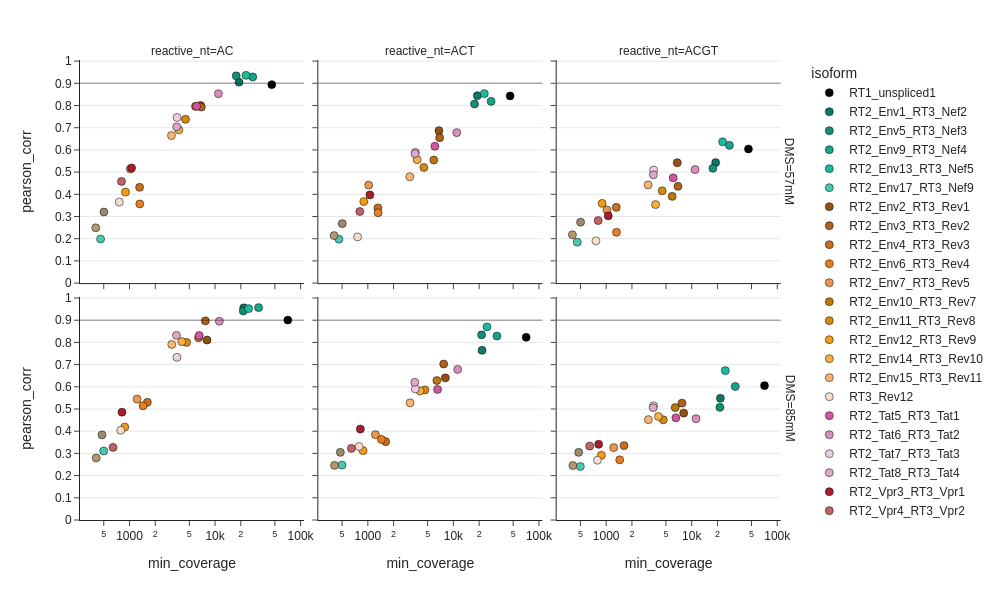

In [76]:

fig = px.scatter(corr_df.dropna(), x="min_coverage", y="pearson_corr", facet_row="DMS", facet_col="reactive_nt", color="isoform",
                 category_orders=order_dict, color_discrete_map = isoform_colors_RT3)
fig.update_xaxes(type="log")
fig.update_yaxes(range=[0,1.005], dtick=0.1)
fig.update_layout(height=600)
fig.update_traces(marker_size=8, marker_line_color="black", marker_line_width=0.5)
fig.add_hline(y=0.9, line_color="black", line_width=1.5)
fig.write_image("figures/log_coverage_vs_corr.svg")
fig.show(renderer='png')

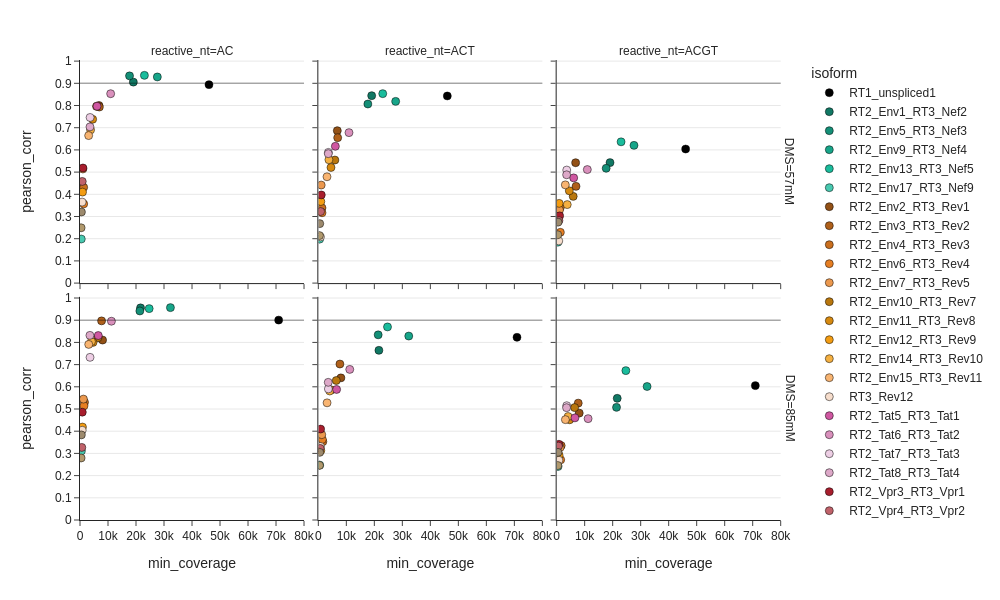

In [78]:

fig = px.scatter(corr_df.dropna(), x="min_coverage", y="pearson_corr", facet_row="DMS", facet_col="reactive_nt", color="isoform",
                 category_orders=order_dict, color_discrete_map = isoform_colors_RT3)
fig.update_yaxes(range=[0,1.005], dtick=0.1)
fig.update_xaxes(range=[0,80000], dtick=10000)
fig.update_layout(height=600)
fig.update_traces(marker_size=8, marker_line_color="black", marker_line_width=0.5)
fig.add_hline(y=0.9, line_color="black", line_width=1.5)
fig.write_image("figures/coverage_vs_corr.svg")
fig.show(renderer='png')

In [79]:
corr_df.to_pickle(f"{data_folder}/rfcombine/corr_df.pickle")

# [Optional] Generate map files (for DeltaSHAPE analysis)

The .map file is a 4-column tab-delimited format. The columns list:

  (1) Nucleotide number (starting at 1)
  
  (2) Probing reactivity
  
  (3) Estimated standard error of the reactivity measurement
  
  (4) Nucleotide identity (A, G, C, U)

Positions for which no reactivity data are available should be included,
with reactivity and standard error values set to -999.


calculation of stderr of ShapeMapper is found here:

https://github.com/Weeks-UNC/shapemapper2/blob/e51a311c5219122307e250165eea6219a6a16019/internals/bin/make_reactivity_profiles.py#L46 

In [ ]:
import numpy as np
def stderr(mutrate, coverage):
    return np.sqrt(mutrate) / np.sqrt(coverage)
    
def stderr_position(stderr_sample, stderr_untreated):
    return np.sqrt((stderr_sample)**2 + (stderr_untreated)**2)

### rf-norm raw

In [ ]:
rfnorm_outdir = f"{data_folder}/rfnorm/"
os.makedirs(rfnorm_outdir, exist_ok=True)

def rf_norm(rf_dir, data_folder, sample, control, isoform, minq=22, num_threads = 10):
    pids = {}

    commands = []
    
    #specify the different rf-count outdir names here
    for option in [f"q{minq}_eq10_ndni"]: 
        
        #running rfnorm with different reactive nt makes it easier to analyze them afterwards (e.g. for correlation analysis)
        for reactive_nt in ["AC", "ACT", "ACGT"]: #["ACGT", "AC", "ACT", "G"]

            rc_file = f"{data_folder}/rfcount/{sample}/{isoform}/{option}/LAST_{isoform}.rc"
            control_rc_file = f"{data_folder}/rfcount/{control}/{isoform}/{option}/LAST_{isoform}.rc"
            
            #standard procedure is using Siegfried method, which normalizes against control sample. 
            #To get raw reactivities (e.g. for evaluation of total (DMS) mutation rates or signal-to-noise calculation, or for MaP analysis) use the following
            
            rfnorm_outdir = f"{data_folder}/rfnorm/{sample}/{isoform}/{option}_{reactive_nt}_raw"
            os.makedirs(rfnorm_outdir, exist_ok=True)
            commands.append(f"{rf_dir}/rf-norm -p {num_threads} -t {rc_file} -o {rfnorm_outdir} --scoring-method 4 -r -rb {reactive_nt} -ow")

    command = "\n".join(commands)

    return command

In [ ]:
slurm_rfnorm = Slurm("rfnorm", {"partition" : "cpu", "mem" : "2G", "cpus-per-task" : num_threads, "time" : "480"})

for sample in samples:

    #Here we assume the sample is structured as following: 
    #"{replicate}_{RT_primer}_{DMS_conc}_{localization}"
    #adjust the list index if DMS_conc is at a different position

    split_sample = sample.split("_")
    split_sample[4] = "0mM"
    control = "_".join(split_sample)
    combined_control = get_combined_sample(control)
    
    combined_sample = get_combined_sample(sample)
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    commands = []
    for isoform in sample_isoforms:
        if isoform in isoforms_per_combined_sample[combined_control]:
            commands.append(rf_norm(rf_dir, data_folder, sample, control, isoform))
    slurm_rfnorm.run("\n".join(commands))

### Read in reactivity from xml file, coverage from tsv and output as .map format

In [ ]:
for sample in samples:

    #Here we assume the sample is structured as following: 
    #"{replicate}_{RT_primer}_{DMS_conc}_{localization}"
    #adjust the list index if DMS_conc is at a different position

    split_sample = sample.split("_")
    split_sample[4] = "0mM"
    control = "_".join(split_sample)
    combined_control = get_combined_sample(control)
    
    combined_sample = get_combined_sample(sample)
    sample_isoforms = isoforms_per_combined_sample[combined_sample]
    
    commands = []
    for isoform in sample_isoforms:
        if isoform in isoforms_per_combined_sample[combined_control]:
            
            coverage_file = f"{data_folder}/bam_stats/{sample}/coverage_{sample}_{isoform}.csv"
            coverage_data = pd.read_csv(coverage_file, sep="\t", names=["RNA", "position", "coverage"])

            control_coverage_file = f"{data_folder}/bam_stats/{control}/coverage_{control}_{isoform}.csv"
            control_coverage_data = pd.read_csv(control_coverage_file, sep="\t", names=["RNA", "position", "coverage"])

            positions = coverage_data["position"].values
            coverage = coverage_data["coverage"].values

            control_coverage = control_coverage_data["coverage"].values
            
            for rfcount_option in [f"q{minq}_eq10_ndni"]:
                for nts in ["ACGT", "AC", "ACT"]: #"ACG", "G"
                    os.makedirs(f"{data_folder}/map_files/{nts}/{RNA}", exist_ok=True)

                    xml_file = f"{data_folder}/rfnorm/{sample}/{isoform}/{rfcount_option}_{nts}_raw/{isoform}.xml"
                    control_xml_file = f"{data_folder}/rfnorm/{control}/{isoform}/{rfcount_option}_{nts}_raw/{isoform}.xml"
                    try:
                        xml_data = read_in_xml(xml_file, sample)
                    except:
                        print("Could not find xml file", xml_file)
                        continue
                    try:
                        control_xml_data = read_in_xml(control_xml_file, sample)
                    except:
                        print("Could not find xml file", control_xml_file)
                        continue

                    reactivity = xml_data["reactivity"]
                    sequence = np.array(list(xml_data["sequence"]))

                    control_reactivity = control_xml_data["reactivity"]

                    stderr_sample = np.sqrt(reactivity) / np.sqrt(coverage)
                    stderr_control = np.sqrt(control_reactivity) / np.sqrt(control_coverage)
                    stderrs = np.sqrt(stderr_sample**2 + stderr_control**2)

                    diff_reactivity = reactivity - control_reactivity

                    tmp_df = pd.DataFrame(np.array([positions, np.nan_to_num(diff_reactivity, nan=-999), np.nan_to_num(stderrs, nan=0), sequence]).T, columns = ["position", "diff_raw_reactivity", "stderr", "nt"])
                    tmp_df["diff_raw_reactivity"] = tmp_df["diff_raw_reactivity"].astype(float)
                    tmp_df["stderr"] = tmp_df["stderr"].astype(float)
                    outfile = f"{data_folder}/rfnorm/{sample}/{isoform}/{rfcount_option}_{nts}_raw/{sample}_{isoform}.map"
                    tmp_df.round(6).to_csv(outfile, sep="\t", float_format='%.6f', header=False, index=False)